In [ ]:
import tensorflow as tf
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# 2. Download the raw file (auto-extract)
download_path = tf.keras.utils.get_file(
    'fp.tgz',
    origin=dataset_url,
    extract=True,
    cache_dir='.'
)

#this making download path a directory
data_dir = pathlib.Path(download_path).with_suffix('')
print(f"SUCCESS! Data located at: {data_dir}")

# 5. Final Count
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"Total images: {image_count}")

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
SUCCESS! Data located at: datasets/fp_extracted
Total images: 0


In [ ]:
print(data_dir.absolute())

/content/datasets/fp_extracted


In [ ]:
#it is nested so we point one step deeper
# iter list all available folders
# next will grab first available folder
data_dir = next(d for d in data_dir.iterdir())

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"Total images: {image_count}")

Total images: 3670


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

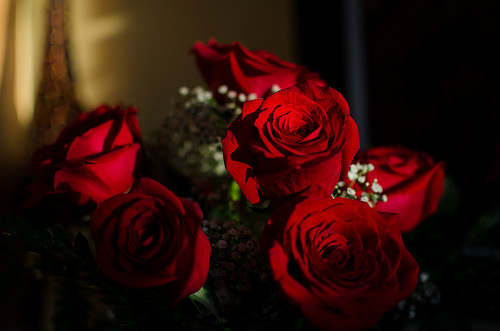

In [ ]:
roses=list(data_dir.glob('roses/*'))
#as roses is pathlib object and PIL expects simple text string so we use converter
PIL.Image.open(str(roses[0]))

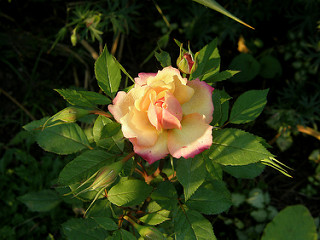

In [ ]:
PIL.Image.open(str(roses[1]))

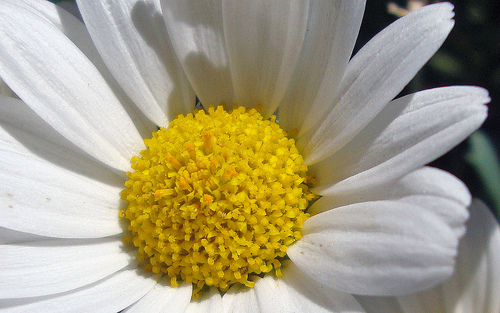

In [ ]:
daisy=list(data_dir.glob('daisy/*'))
PIL.Image.open(str(daisy[10]))


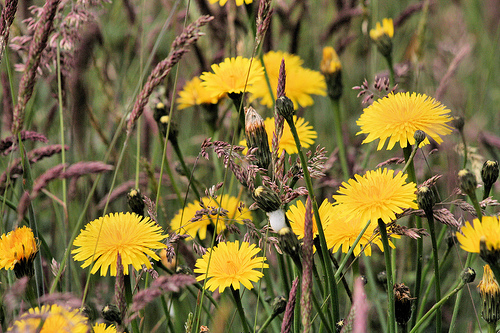

In [ ]:
dandelion=list(data_dir.glob('dandelion/*'))
PIL.Image.open(str(dandelion[18]))

In [ ]:
batch_size=32
img_height=180
img_width=180

In [ ]:
train_ds=tf.keras.utils.image_dataset_from_directory(data_dir,validation_split=0.2,subset='training',seed=123,image_size=(img_height,img_width),batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
print(train_ds.element_spec)

(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [ ]:
validation_ts=tf.keras.utils.image_dataset_from_directory(data_dir,validation_split=0.2,seed=123,subset='validation',image_size=(img_height,img_width),batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
#ds_train i not matrix it is tensor object
p=train_ds.class_names
print(p)
c=p

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
i, s = next(iter(train_ds.take(1)))
#iter list all batches with labels
#next pick first available batch
# for safety(intentionally want first batch) .take(1) use for eliminate all batches except first batch
print(f"Shape of image batch: {i.shape}")
print(f"Shape of label batch: {s.shape}")
print(f"Shape of second image in batch: {i[1].shape}")

Shape of image batch: (32, 180, 180, 3)
Shape of label batch: (32,)
Shape of second image in batch: (180, 180, 3)


In [ ]:
images, labels = next(iter(train_ds))

In [ ]:
print(f"Shape of image batch: {images.shape}")

Shape of image batch: (32, 180, 180, 3)


In [ ]:
i.shape

TensorShape([32, 180, 180, 3])

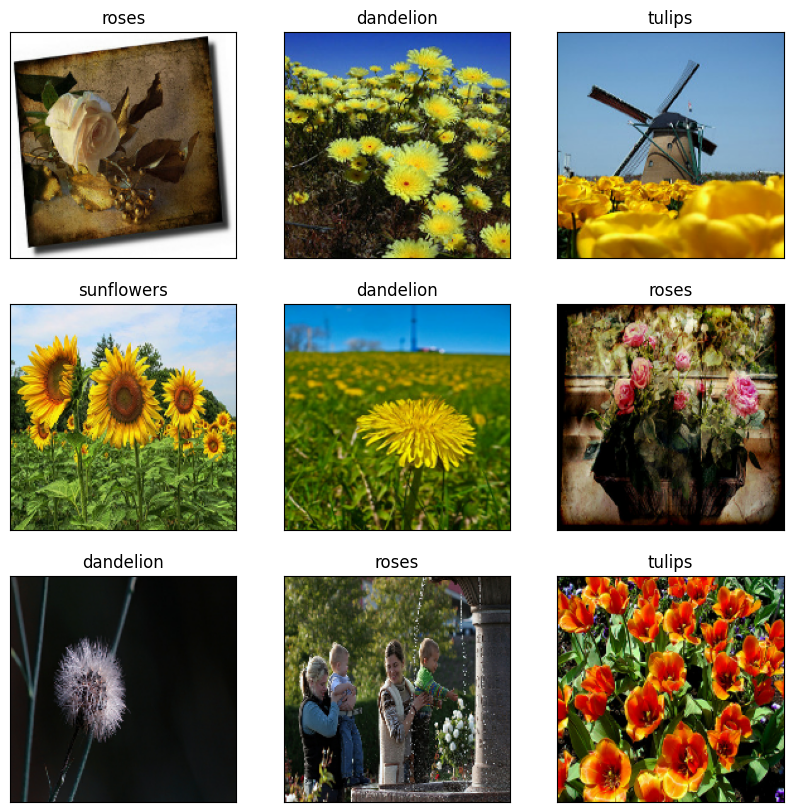

In [ ]:
import matplotlib.pyplot as plt
#size=width,height
plt.figure(figsize=(10, 10))
for p in range(9):
  plt.subplot(3,3,p+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(i[p].numpy().astype("uint8"))
  plt.title(c[s[p]])

In [ ]:
AUTOTUNE=tf.data.AUTOTUNE
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ts=validation_ts.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer=tf.keras.layers.Rescaling(1./255)
# when we use lambda for tf.data we use :() this additional bracket not used in normal python code
#non tensor- result = map(function, iterable)
#tensor    - new_ds = old_ds.map(fn)
normalized_ds=train_ds.map(lambda x,y:(normalization_layer(x),y))

In [ ]:
import numpy as np
#NumPy then automatically triggers the .numpy() conversion in the background, grabs the values, and calculates the max/min.
img,lab=next(iter(normalized_ds))
k,n=np.max(img[1]),np.min(img[1])
k,n

(np.float32(0.9990197), np.float32(0.0))

In [ ]:
#While this is fine for checking values (like you are doing now), never use NumPy functions inside your
#training loop (e.g., inside model.fit or a custom loss function).Why? It breaks the GPU acceleration pipeline because NumPy cannot run on
#the GPU. It forces the data to travel back to the CPU for that one calculation, slowing everything down.
#Building the Model: Always use TensorFlow equivalents (e.g., tf.reduce_max instead of np.max) to keep the speed high.
t=tf.reduce_max(img[1])
t

<tf.Tensor: shape=(), dtype=float32, numpy=0.9990196824073792>

In [ ]:
#by using input shape we able to generate model summury it expects (img_height,img_width,dimension(rgb))

In [ ]:
num_classes = len(c)
from tensorflow.keras import layers

In [ ]:
#in RGB each filter is NOT 3×3. It is: 3 × 3 × 3. The operation: output
 # In words: Multiply each RGB patch with its corresponding weights Sum across space AND across channels Add bias Apply activation (ReLU).
 # This gives one number.
 # input (224,224)
 # Feature map k → (224 × 224)

In [ ]:
# convolutional layer Parallel (correct) All 16 filters: see the same input tensor slide over it simultaneously
#each produces its own feature map
 # input (224,224,3)
 # Feature map k → (224 × 224,16)

In [ ]:
model=tf.keras.Sequential([layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),
                           layers.Conv2D(16,3,activation='relu'),
                           layers.MaxPooling2D(),
                           layers.Conv2D(16,3,padding='same',activation='relu'),
                           layers.MaxPooling2D(),
                           layers.Conv2D(16,3,padding='same',activation='relu'),
                           layers.MaxPooling2D(),
                           layers.Conv2D(16,3,padding='same',activation='relu'),
                           layers.MaxPooling2D(),
                           layers.Flatten(),
                           layers.Dense(128,activation='relu'),
                           layers.Dense(num_classes)
                           ])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#No activation(softmax) means this layer outputs raw scores, logits. So for num_classes = 5, the output looks like: [ 2.3, -1.1, 0.7, 4.9, 0.2 ]
#These are not probabilities.They don’t sum to 1.
# why using softmax in loss: Why this is often better (important)
#Using logits + from_logits=True is better because:
#avoids numerical overflow,combines softmax + log into one stable operation,is what serious implementations use

In [ ]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 89, 89, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 44, 44, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 44, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1936)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       247,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 255,989 (999.96 KB)

 Trainable params: 255,989 (999.96 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs=15
history=model.fit(train_ds,validation_data=validation_ts,batch_size=64,epochs=epochs)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.3007 - loss: 1.5182 - val_accuracy: 0.5272 - val_loss: 1.1763
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5497 - loss: 1.1023 - val_accuracy: 0.5872 - val_loss: 1.0333
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6220 - loss: 0.9766 - val_accuracy: 0.5790 - val_loss: 0.9794
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6448 - loss: 0.9164 - val_accuracy: 0.6090 - val_loss: 0.9279
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6988 - loss: 0.7917 - val_accuracy: 0.6335 - val_loss: 0.9015
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7147 - loss: 0.7420 - val_accuracy: 0.6635 - val_loss: 0.8428
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7418 - loss: 0.6814 - val_accuracy: 0.6485 - val_loss: 0.8473
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7785 - loss: 0.5886 - val_accuracy: 0.6567 - 

In [ ]:
accuracy=history.history['accuracy']
loss=history.history['loss']
val_accu=history.history['val_accuracy']
validation_loss=history.history['val_loss']

In [ ]:
epochs=range(epochs)
print(accuracy)

[0.35865122079849243, 0.5674387216567993, 0.6093324422836304, 0.6454359889030457, 0.6815395355224609, 0.7210490703582764, 0.7391008138656616, 0.7724795937538147, 0.8034741282463074, 0.8273161053657532, 0.8767030239105225, 0.8858991861343384, 0.9141689538955688, 0.9250681400299072, 0.9598092436790466]


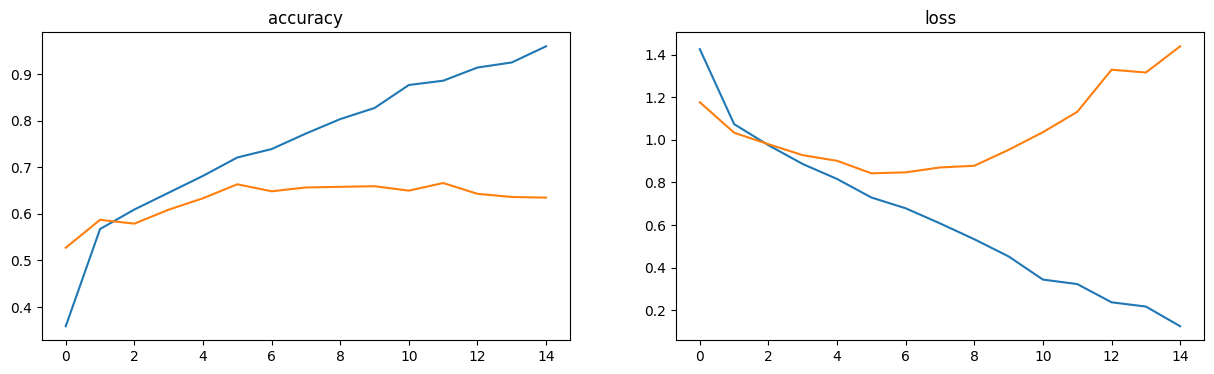

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(epochs,accuracy)
plt.plot(epochs,val_accu)
plt.title('accuracy')

plt.subplot(1,2,2)
plt.plot(epochs,loss)
plt.plot(epochs,validation_loss)
plt.title('loss')
plt.show()

In [ ]:
data_augumentation=tf.keras.Sequential([layers.RandomFlip('horizontal',input_shape=(img_height,img_width,3)),
                                      layers.RandomRotation(0.1),layers.RandomZoom(0.1)])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


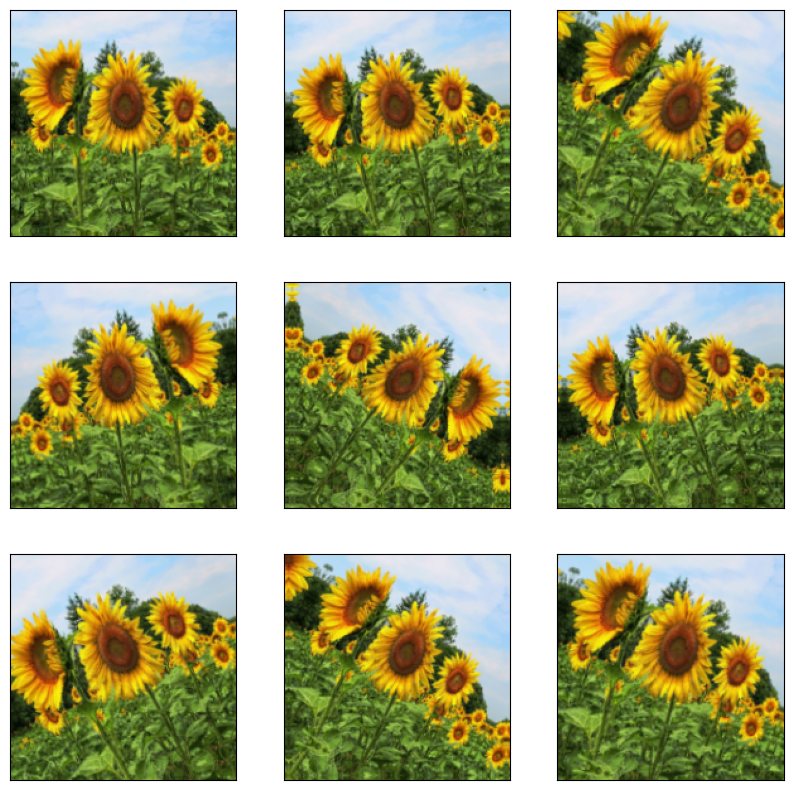

In [ ]:
plt.figure(figsize=(10,10))
for w in range(9):
  extracted=data_augumentation(i)
  plt.subplot(3,3,w+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(extracted[3].numpy().astype("uint8"))

In [ ]:
model=tf.keras.Sequential([data_augumentation,layers.Rescaling(1./255), layers.Conv2D(16,3,activation='relu'),
                           layers.MaxPooling2D(),
                           layers.Conv2D(16,3,padding='same',activation='relu'),
                           layers.MaxPooling2D(),
                           layers.Conv2D(16,3,padding='same',activation='relu'),
                           layers.MaxPooling2D(),
                           layers.Conv2D(16,3,padding='same',activation='relu'),
                           layers.MaxPooling2D(),
                           layers.Dropout(0.2),
                           layers.Flatten(),
                           layers.Dense(128,activation='relu'),
                           layers.Dense(num_classes,name='outputs')
                           ])

In [ ]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [17]:
epochs=1

In [18]:
history=model.fit(train_ds,validation_data=validation_ts,epochs=epochs)

92/92 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.4717 - loss: 1.2333 - val_accuracy: 0.5313 - val_loss: 1.1191


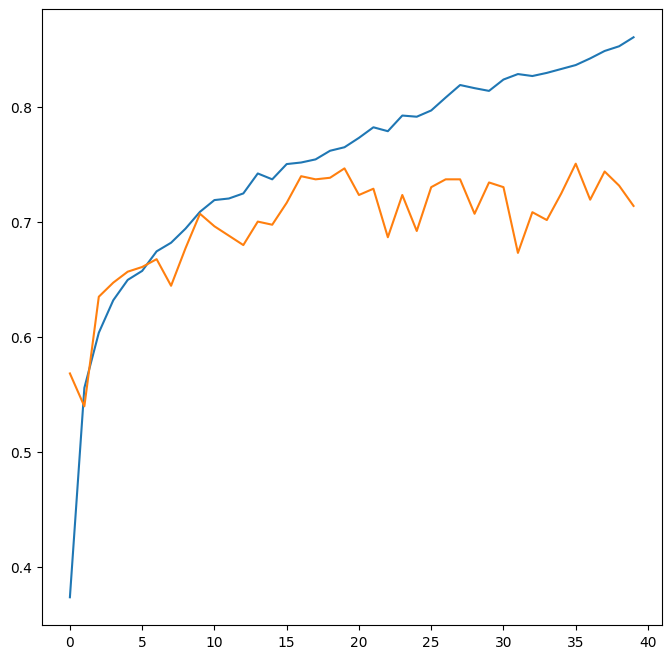

In [ ]:
epochs=range(epochs)
val_accu=history.history['val_accuracy']
accu=history.history['accuracy']
fig=plt.figure(figsize=(8,8))
plt.plot(epochs,accu)
plt.plot(epochs,val_accu)
plt.show()

In [ ]:
download_url="https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
suflower_path=tf.keras.utils.get_file('red_sunflower',origin=download_url)

117948/117948 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
img=tf.keras.utils.load_img(suflower_path,target_size=(img_height,img_width))
img_array=tf.keras.utils.img_to_array(img)
img_batch=tf.expand_dims(img_array,0)
#The argument axis=0 tells TensorFlow where in the shape list to insert the new number 1.

In [ ]:
result=model.predict(img_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


In [ ]:
print(result)

[[-4.6699347   0.02649613  1.3753942   4.4619164   1.6084327 ]]


In [ ]:
score=tf.nn.softmax(result)

In [ ]:
score

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[9.6986332e-05, 1.0625381e-02, 4.0941488e-02, 8.9665037e-01,
        5.1685762e-02]], dtype=float32)>

In [ ]:
p

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
print('this image is mostly like to {} and chance of matching is {:.1f} percent'.format(p[np.argmax(score)],np.max(score)*100))

this image is mostly like to sunflowers and chance of matching 89.7 percent


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/colab_model/flower_model.h5')

In [20]:
#Convert the Keras Sequential model to a TensorFlow Lite model
converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert()

Saved artifact at '/tmp/tmpop9hre38'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  135450096413264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135450096414032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135450096414992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135450096413456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135450096415184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135450096415952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135450096417680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135450096416144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135450096418064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135450096417872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135450096413

In [22]:
with open('/content/drive/MyDrive/colab_model/flower2model.tflite','wb') as f:
  f.write(tflite_model)


In [25]:
!git clone https://github.com/mangalneeraj3/Deep_learnning_moodels.git

Cloning into 'Deep_learnning_moodels'...


In [26]:
%cd Deep_learnning_moodels
!git status

/content/Deep_learnning_moodels
On branch main

No commits yet

nothing to commit (create/copy files and use "git add" to track)


In [30]:
!ls "/content/drive/MyDrive/Colab Notebooks"


'CNN rice classification.ipynb'		  Mnist.ipynb	       Untitled
'Copy of CNN rice classification.ipynb'  'nlp bASICS.ipynb'    Untitled0.ipynb
'Copy of Fashion_Mnist.ipynb'		  NN2.ipynb	       Untitled1.ipynb
 Fashion_Mnist.ipynb			  NN3_graph.ipynb      Untitled2.ipynb
'flower classification.ipynb'		 'NN(titanic).ipynb'
